In [4]:
%pylab inline
import matplotlib as mpl
mpl.rcParams['mathtext.default'] = 'rm'

Populating the interactive namespace from numpy and matplotlib


In [5]:
import numpy as np
import pandas as pd
import h5py, itertools, scipy.stats
import matplotlib.pyplot as plt
import sys, os, re
from scipy.special import erf
from scipy.optimize import curve_fit
from andrew_tools.simple_tools import high_low_limit
import Claires_modules

def normal_cdf(x,sigma,mu):
    return 0.5*(1.0+erf((x-mu)/(sigma*np.sqrt(2.0))))

In [1]:
#Here I'm going to write a program that does a KS test very quickly
#what I did before was very dumb, and not good for a "best-fit" analysis

#basic script of the program

#ooooo new idea, see how these parameters vary as a function of
#halo mass or other subhalo parameters

#1) initialize a matrix of mu and sigma values (maybe a 2d array?)
#2) for every column (or row) in this array calculate a mask
#   that gives the true/false values for every mu/sigma for each
#   subhalo of each MW sim
#3) apply those masks to the subhalo distances
#4) find the median (or mean) of that distribution
#
# * maybe do the mean/median first as a separate calculation? *
# * I also need to figure out how to apply Claire's program
#   double check it, and include every galaxy down to V_max of 5?*

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:42: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:92: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


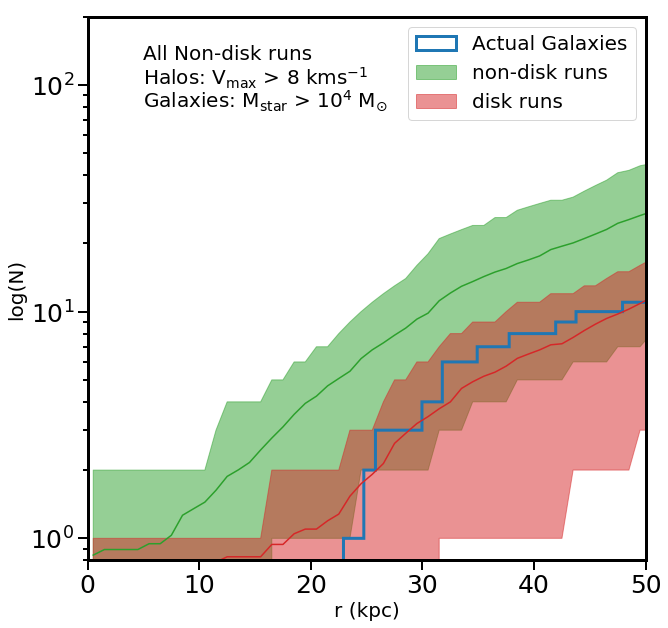

In [185]:
#okay now the compilation of all the sims observed with mock SDSS and
#DES like surveys

h = 0.6751

total_len = 0
total_hist = None

disk_total_len = 0
disk_total_hist = None

for data_file in os.listdir('../../initial_test_with_ELVIS/Tyler_Data/'):
    f_halos = h5py.File('../../initial_test_with_ELVIS/Tyler_Data/'+data_file)
    halo_name = data_file.split('_')[2]
    #print halo_name
    Data_M = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Vmax'][:]
    Data_Mass = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Mvir'][:]/h
    Data_cens = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Center'][:]/h
    Data_X = Data_cens[:,0]
    Data_Y = Data_cens[:,1]
    Data_Z = Data_cens[:,2]
    Data_Rvir = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Rvir'][:]/h
    
    M_t = 8.0
    
    Vmax_mask = (Data_M>8.0)
    
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    
    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    
    Andr = 0
    MW = host_index

    hist_matrix, radius_bins = Claires_modules.calc_corr_factors(Data_X_cut, Data_Y_cut, Data_Z_cut, Data_M_cut, Data_Rvir_cut, MW, Andr)
        
    if total_hist == None:
        total_hist = hist_matrix
    else:
        total_hist = np.concatenate((total_hist,hist_matrix),axis=0)
    
    total_len += len(hist_matrix)

plot_bins = [(radius_bins[ii]+radius_bins[ii+1])*1000.0/2.0 for ii in range(len(radius_bins)-1)]

min_line = [np.min(total_hist[:,ii]) for ii in range(len(total_hist[0]))]
max_line = [np.max(total_hist[:,ii]) for ii in range(len(total_hist[0]))]
med_line = [np.mean(total_hist[:,ii]) for ii in range(len(total_hist[0]))]

hl_line = [high_low_limit(total_hist[:,ii],0.68) for ii in range(len(total_hist[0]))]

low_line = [xx[0] for xx in hl_line]
high_line = [xx[1] for xx in hl_line]

plot_top = max_line[-1]

# Now do the same for the disk runs

for data_file in os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data/'):
    f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_disk_data/'+data_file)
    halo_name = re.split('_|\.',str(data_file))[2]
    Data_M = f_halos[:,3]
    Data_X = f_halos[:,0]/h
    Data_Y = f_halos[:,1]/h
    Data_Z = f_halos[:,2]/h
    Data_Rvir = f_halos[:,5]/h
    Data_Mass = f_halos[:,4]/h
    
    M_t = 8.0
    
    Vmax_mask = (Data_M>8.0)
    
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    
    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    
    Andr = 0
    MW = host_index

    hist_matrix, radius_bins = Claires_modules.calc_corr_factors(Data_X_cut, Data_Y_cut, Data_Z_cut, Data_M_cut, Data_Rvir_cut, MW, Andr)
        
    if disk_total_hist == None:
        disk_total_hist = hist_matrix
    else:
        disk_total_hist = np.concatenate((disk_total_hist,hist_matrix),axis=0)
    
    disk_total_len += len(hist_matrix)

disk_min_line = [np.min(disk_total_hist[:,ii]) for ii in range(len(disk_total_hist[0]))]
disk_max_line = [np.max(disk_total_hist[:,ii]) for ii in range(len(disk_total_hist[0]))]
disk_med_line = [np.mean(disk_total_hist[:,ii]) for ii in range(len(disk_total_hist[0]))]

disk_hl_line = [high_low_limit(disk_total_hist[:,ii],0.68) for ii in range(len(disk_total_hist[0]))]

disk_low_line = [xx[0] for xx in disk_hl_line]
disk_high_line = [xx[1] for xx in disk_hl_line]


f_dat = np.loadtxt('../../Sats_data.csv',delimiter=',',dtype=object)
gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

large_gal_mask = (gal_mass>1.0e4)&(gal_dist<R_vir_host)

large_gal_dist = gal_dist[large_gal_mask]
#print large_gal_dist

plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([0.0,50.0])
plt.ylim([0.8,200.0])
plt.xlabel('r (kpc)',fontsize=20)
plt.ylabel('log(N)',fontsize=20)
plt.yscale('log')

plt.text(5.0,130.0,'All Non-disk runs',fontsize=20)
plt.text(5.0,100.0,'Halos: $V_{max}$ > 8 $kms^{-1}$',fontsize=20)
plt.text(5.0,80.0,'Galaxies: $M_{star}$ > $10^4$ $M_{\odot}$',fontsize=20)

plt.hist(gal_dist,bins=np.linspace(0.0,R_vir_host,1000),cumulative=True,histtype='step',linewidth=3,label='Actual Galaxies')

plt.fill_between(plot_bins,low_line,high_line,color='C2',alpha=0.5,label='non-disk runs')
plt.plot(plot_bins,med_line,color='C2')

plt.fill_between(plot_bins,disk_low_line,disk_high_line,color='C3',alpha=0.5,label='disk runs')
plt.plot(plot_bins,disk_med_line,color='C3')

#plt.yscale('log')
plt.legend(loc=1, prop={'size': 20})
#plt.savefig('./radial_projections.png',bbox_inches='tight')
plt.show()

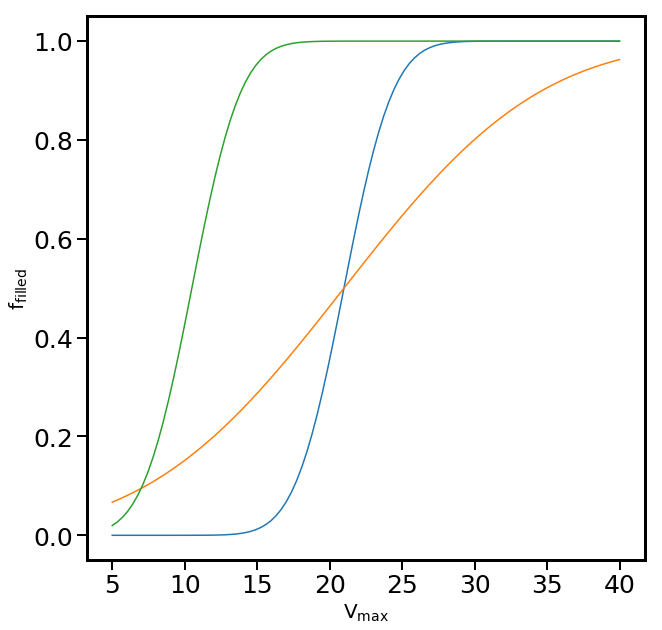

In [187]:
def normal_cdf(x,sigma,mu):
    return 0.5*(1.0+erf((x-mu)/(sigma*np.sqrt(2.0))))

v_max_fit = np.linspace(5.0,40.0,100)

popt = [2.66718967, 20.98533531]
popt_wide = [2.66718967*4.0, 20.98533531]
popt_low = [2.66718967, 20.98533531/2.0]
popt_bad = [14.5,0.0]

orig_fit = normal_cdf(v_max_fit,*popt)
wide_fit = normal_cdf(v_max_fit,*popt_wide)
low_fit = normal_cdf(v_max_fit,*popt_low)
bad_fit = normal_cdf(v_max_fit,*popt_bad)

plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
#plt.xlim([-10.0,1.0])
#plt.ylim([10.0,1000.0])
plt.xlabel('$V_{max}$',fontsize=20)
plt.ylabel('$f_{filled}$',fontsize=20)

plt.plot(v_max_fit,orig_fit,color='C0')
plt.plot(v_max_fit,wide_fit,color='C1')
plt.plot(v_max_fit,low_fit,color='C2')
#plt.plot(v_max_fit,bad_fit,color='C3')

#plt.legend(loc=1, prop={'size': 20})
#plt.xscale('log')
#plt.savefig('./all_halos_shade.png',bbox_inches='tight')
plt.show()

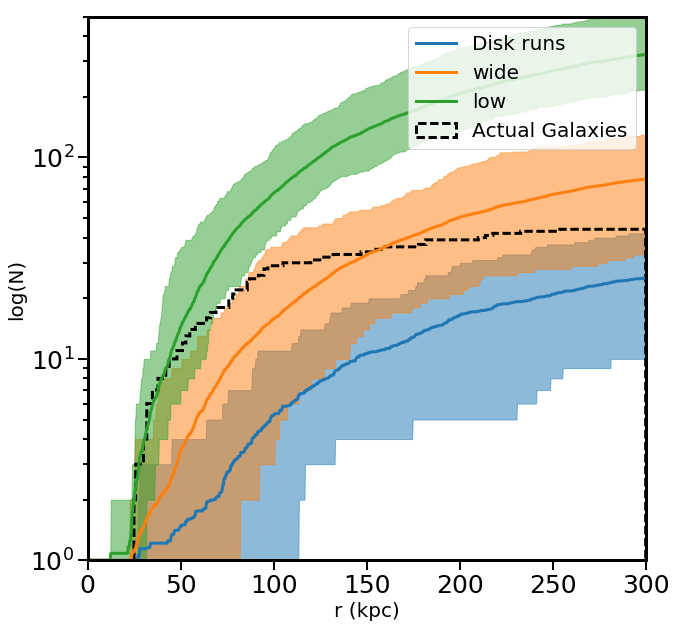

In [47]:
#begin by applying the filter to just the radial functions
#without a radial correction

#okay here are the vmax bins, I might eventually fit a function
#actually I should just fit a function
def normal_cdf(x,sigma,mu):
    return 0.5*(1.0+erf((x-mu)/(sigma*np.sqrt(2.0))))

#now if I use a normalized cdf the fit parameters are sigma = 2.66718967  mu = 20.98533531 for Vmax

popt = [2.66718967, 20.98533531]
popt_wide = [2.66718967*4.0, 20.98533531]
popt_low = [2.66718967, 5.0]

h = 0.6751

disk_files = len(os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'))

disk_hist_matrix = np.zeros((disk_files*10,1000)) 
wide_hist_matrix = np.zeros((disk_files*10,1000)) 
low_hist_matrix = np.zeros((disk_files*10,1000))

disk_iter = 0
    
for data_file in os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'):
    for kk in range(10):
        
        f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'+data_file)
        Data_M = f_halos[:,3]
        Data_X = f_halos[:,0]*1000.0/h
        Data_Y = f_halos[:,1]*1000.0/h
        Data_Z = f_halos[:,2]*1000.0/h
        Data_Rvir = f_halos[:,5]/h
        Data_Mass = f_halos[:,4]/h
        Data_Vpeak = f_halos[:,6]

        M_t = 8.0

        Vmax_mask = (Data_M>M_t)

        Data_X_cut = Data_X[Vmax_mask]
        Data_Y_cut = Data_Y[Vmax_mask]
        Data_Z_cut = Data_Z[Vmax_mask]
        Data_M_cut = Data_M[Vmax_mask]
        filled_frac = normal_cdf(Data_M_cut,*popt)
        Data_Rvir_cut = Data_Rvir[Vmax_mask]
        Data_cens_cut = np.vstack((Data_X_cut,Data_Y_cut,Data_Z_cut)).T
        Data_Vpeak_cut = Data_Vpeak[Vmax_mask]

        host_index = np.argmax(Data_M_cut)
        R_vir_host = Data_Rvir_cut[host_index]
        host_cen = np.array([Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]])

        coord_dist = Data_cens_cut - host_cen
        distances_from_center = np.linalg.norm(coord_dist,axis=1)

        filled_frac = normal_cdf(Data_Vpeak_cut,*popt)
        filled_frac_wide = normal_cdf(Data_Vpeak_cut,*popt_wide)
        filled_frac_low = normal_cdf(Data_Vpeak_cut,*popt_low)
        
        weighted_coin_flip = np.array([True if random.random() < xx else False for xx in filled_frac])
        weighted_coin_flip_wide = np.array([True if random.random() < xx else False for xx in filled_frac_wide])
        weighted_coin_flip_low = np.array([True if random.random() < xx else False for xx in filled_frac_low])
        
        #print len(Data_X), np.sum(Vmax_mask), np.sum(weighted_coin_flip)
        
        disk_hist, disk_bins = np.histogram(distances_from_center[weighted_coin_flip],bins=np.linspace(0.0,300.0,1001))
        disk_hist_c = np.cumsum(disk_hist)
        disk_hist_matrix[disk_iter] = disk_hist_c
        
        wide_hist, wide_bins = np.histogram(distances_from_center[weighted_coin_flip_wide],bins=np.linspace(0.0,300.0,1001))
        wide_hist_c = np.cumsum(wide_hist)
        wide_hist_matrix[disk_iter] = wide_hist_c
        
        low_hist, low_bins = np.histogram(distances_from_center[weighted_coin_flip_low],bins=np.linspace(0.0,300.0,1001))
        low_hist_c = np.cumsum(low_hist)
        low_hist_matrix[disk_iter] = low_hist_c
        disk_iter += 1
    
r_list = np.linspace(0.0,300.0,1001)
    
r_list_plot = [(r_list[ii]+r_list[ii+1])/2.0 for ii in range(len(r_list)-1)]
#min_line = [np.min(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]
#max_line = [np.max(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]
#med_line = [np.mean(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]

disk_min_line = [np.min(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]
disk_max_line = [np.max(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]
disk_med_line = [np.mean(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]

wide_min_line = [np.min(wide_hist_matrix[:,ii]) for ii in range(len(wide_hist_matrix[0]))]
wide_max_line = [np.max(wide_hist_matrix[:,ii]) for ii in range(len(wide_hist_matrix[0]))]
wide_med_line = [np.mean(wide_hist_matrix[:,ii]) for ii in range(len(wide_hist_matrix[0]))]

low_min_line = [np.min(low_hist_matrix[:,ii]) for ii in range(len(low_hist_matrix[0]))]
low_max_line = [np.max(low_hist_matrix[:,ii]) for ii in range(len(low_hist_matrix[0]))]
low_med_line = [np.mean(low_hist_matrix[:,ii]) for ii in range(len(low_hist_matrix[0]))]

f_dat = np.loadtxt('../../Sats_data.csv',delimiter=',',dtype=object)
gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

large_gal_mask = (gal_mass>1.0e4)&(gal_dist<R_vir_host)

large_gal_dist = gal_dist[large_gal_mask]
    
plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([0.0,300.0])
plt.ylim([1.0,500.0])
plt.xlabel('r (kpc)',fontsize=20)
plt.ylabel('log(N)',fontsize=20)
#plt.fill_between(r_list_plot,min_line,max_line,color='C0',alpha=0.5)
#plt.plot(r_list_plot,med_line,linewidth=3,color='C0',label='DMO runs')

plt.fill_between(r_list_plot,disk_min_line,disk_max_line,color='C0',alpha=0.5)
plt.plot(r_list_plot,disk_med_line,linewidth=3,color='C0',label='Disk runs')

plt.fill_between(r_list_plot,wide_min_line,wide_max_line,color='C1',alpha=0.5)
plt.plot(r_list_plot,wide_med_line,linewidth=3,color='C1',label='wide')

plt.fill_between(r_list_plot,low_min_line,low_max_line,color='C2',alpha=0.5)
plt.plot(r_list_plot,low_med_line,linewidth=3,color='C2',label='low')

#plt.hist(gal_dist,bins=np.linspace(0.0,R_vir_host,1000),cumulative=True,histtype='step',linewidth=3,color='k',linestyle='--',label='Actual Galaxies')
data_hist, data_bins, data_patches = plt.hist(gal_dist,bins=r_list,cumulative=True,histtype='step',linewidth=3,color='k',linestyle='--',label='Actual Galaxies')

plt.yscale('log')
plt.legend(loc=1, prop={'size': 20})
#plt.savefig('./all_halos_shade.png',bbox_inches='tight')
plt.show()

In [164]:
combined = np.stack(np.meshgrid(mu_list,sigma_list),-1).reshape(-1,2)
#how this above function works
# 1) meshgrid makes Nd mesh (this case 3d) where one dimension is the mu_list and one is the sigma_list
# 2) stack -1 takes the transpose?
# 3) and then you have to reshape the matrix to 2d

#Now I want to take in all of Tyler's sims and cut the data/calculate distances
#we want to do this separately to save time

#I think I want to save this data as a dictionary for easy calling

h = 0.6751

halo_dict = {}

for data_file in os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'):
    h_number = data_file.split('_')[2]
    f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'+data_file)
    Data_M = f_halos[:,3]
    Data_X = f_halos[:,0]*1000.0/h
    Data_Y = f_halos[:,1]*1000.0/h
    Data_Z = f_halos[:,2]*1000.0/h
    Data_Rvir = f_halos[:,5]/h
    Data_Vmax = f_halos[:,4]/h
    Data_Vpeak = f_halos[:,6]

    M_t = 5.0

    Vmax_mask = (Data_M>M_t)

    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    Data_cens_cut = np.vstack((Data_X_cut,Data_Y_cut,Data_Z_cut)).T
    Data_Vpeak_cut = Data_Vpeak[Vmax_mask]
    Data_Vmax_cut = Data_Vmax[Vmax_mask]

    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    host_cen = np.array([Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]])

    coord_dist = Data_cens_cut - host_cen
    distances_from_center = np.linalg.norm(coord_dist,axis=1)

    halo_dict[h_number] = {'mass':Data_M_cut,'Vpeak':Data_Vpeak_cut,'Vmax':Data_Vmax_cut,'distances':distances_from_center}

In [165]:
#fit only where there's data

mu_list = np.linspace(5.0,30.0,100)
sigma_list = np.linspace(0.0,20.0,100)

#okay now that I have that I need to find an efficient way to apply the "coin flip" to this multiple times for
#each run of this matrix

#1) apply cdf to the Vpeak of one sim multiple times

r_list = np.linspace(20.0,50.0,26)
r_list_plot = [(r_list[ii]+r_list[ii+1])/2.0 for ii in range(len(r_list)-1)]

f_dat = np.loadtxt('../../Sats_data.csv',delimiter=',',dtype=object)
gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

data_hist, data_bins = np.histogram(gal_dist,bins=r_list)
galaxies_hist_cum = np.cumsum(data_hist)

print np.min(gal_dist)

def normal_cdf(x,sigma,mu):
    return 0.5*(1.0+erf((x-mu)/(sigma*np.sqrt(2.0))))

#Now I want to apply the cdf function to all the Vpeak data
#this will give an array for each sim with the len of how many halos are in that sim

n_iter = 10

ks_total = []

for mu_select in mu_list:
    for sigma_select in sigma_list:
        popt = [sigma_select,mu_select]
        
        #now I need to initalize an empty matrix to hold all the data
        #for whatever reason the colums need to be the exact shape
        #you need, so in this case 1000 which is the number of bins
        
        hist_total = np.empty((0,25))
        
        for selected_halo in halo_dict.keys():
            Vpeak_select = halo_dict[selected_halo]['Vpeak']
            dist_select = halo_dict[selected_halo]['distances']
            
            #create a random sample that has a number of columns correspondng to the number of halos
            #and a number of rows that is the number of iterations I want
            
            dist_broadcast = np.broadcast_to(dist_select,(n_iter,len(dist_select)))

            #print len(Vpeak_select)

            cf_matrix = random.random_sample((n_iter,len(Vpeak_select)))
            #Now apply this matrix as a mask based on a matrix that is the probabilities of a halo
            #being filled according to the sigma and mu (this must be broadcast to the shape of
            #the cf matrix)

            fill_probabilities = np.broadcast_to(normal_cdf(Vpeak_select,*popt),(n_iter,len(Vpeak_select)))

            #np.broadcast_to(fill_probabilities,(n_iter,len(Vpeak_select)))
            assert cf_matrix.shape==fill_probabilities.shape

            #apply fill probabilities to cf_matrix

            cf_mask = (fill_probabilities>cf_matrix)

            #now I need to use a masked array in order to preseve shape:
            masked_distances = np.ma.array(dist_broadcast,mask=np.logical_not(cf_mask))

            assert fill_probabilities.shape==masked_distances.shape

            #is there a way I can bin these histograms which takes into account the fact that data is missing?
            #I could potentially use apply along axis method

            r_bins = np.linspace(20.0,50.0,26)

            histogram_matrix = np.apply_along_axis(lambda a: np.histogram(a.compressed(),bins=r_bins)[0], 1, masked_distances)
            cumulative_histogram_matrix = np.cumsum(histogram_matrix,axis=1)
            
            #print cumulative_histogram_matrix

            hist_total = np.concatenate([hist_total,cumulative_histogram_matrix])
            
        select_med_line = np.array([np.mean(hist_total[:,ii]) for ii in range(len(hist_total[0]))])
        
        ks_test = scipy.stats.ks_2samp(galaxies_hist_cum,select_med_line)
        #print 'mu: {}, sigma: {}'.format(mu_select,sigma_select)
        #print galaxies_hist_cum
        #print select_med_line
        #print ks_test
        
        ks_total.append(ks_test)

23.0


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:66: RuntimeWarning: invalid value encountered in greater


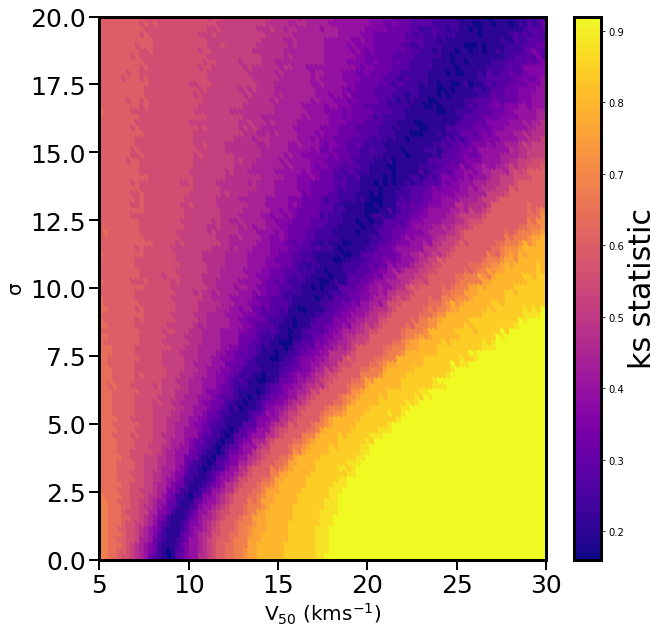

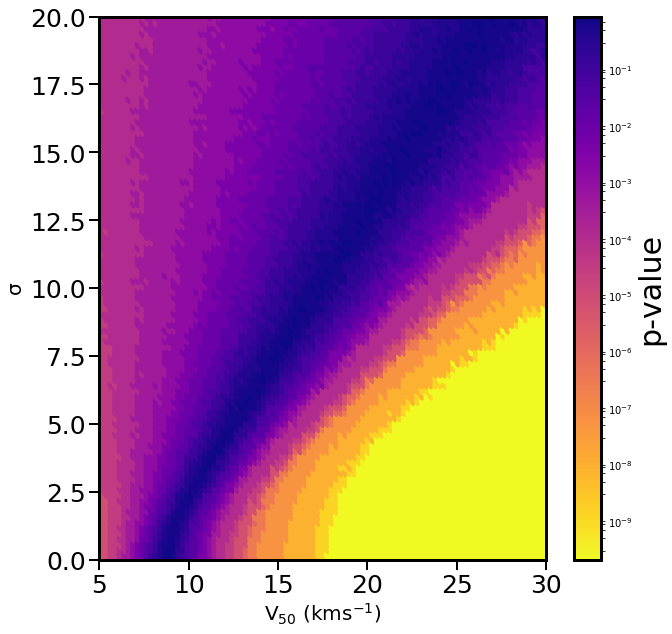

In [169]:
ks_sample = [xx[0] for xx in ks_total]
p_vals = [xx[1] for xx in ks_total]

#print ks_sample

mu_plot,sigma_plot = [],[]

#print sorted(ks_sample)

for mu_select in mu_list:
    for sigma_select in sigma_list:
        mu_plot.append(mu_select)
        sigma_plot.append(sigma_select)

min_index = np.argmin(ks_sample)

#print 'mu: {}, sigma: {}, ks: {}'.format(mu_plot[min_index],sigma_plot[min_index],ks_sample[min_index])
        
#print ks_sample

plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([5.0,30.0])
plt.ylim([0.0,20.0])
plt.xlabel('$V_{50}$ $(km s^{-1})$',fontsize=20)
plt.ylabel(r'$\sigma$',fontsize=20)

plt.scatter(mu_plot,sigma_plot,c=ks_sample,cmap='plasma',s=100)
cbar = plt.colorbar()
cbar.set_label('ks statistic',fontsize=30)
plt.show()


plt.figure(2,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([5.0,30.0])
plt.ylim([0.0,20.0])
plt.xlabel('$V_{50}$ $(km s^{-1})$',fontsize=20)
plt.ylabel(r'$\sigma$',fontsize=20)

plt.scatter(mu_plot,sigma_plot,c=p_vals,cmap='plasma_r',norm=matplotlib.colors.LogNorm(),s=100)
cbar = plt.colorbar()
cbar.set_label('p-value',fontsize=30)
plt.show()

In [170]:
#fit everywhere

mu_list = np.linspace(5.0,30.0,100)
sigma_list = np.linspace(0.0,20.0,100)

#okay now that I have that I need to find an efficient way to apply the "coin flip" to this multiple times for
#each run of this matrix

#1) apply cdf to the Vpeak of one sim multiple times

r_list = np.linspace(0.0,50.0,26)
r_list_plot = [(r_list[ii]+r_list[ii+1])/2.0 for ii in range(len(r_list)-1)]

f_dat = np.loadtxt('../../Sats_data.csv',delimiter=',',dtype=object)
gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

data_hist, data_bins = np.histogram(gal_dist,bins=r_list)
galaxies_hist_cum = np.cumsum(data_hist)

print np.min(gal_dist)

def normal_cdf(x,sigma,mu):
    return 0.5*(1.0+erf((x-mu)/(sigma*np.sqrt(2.0))))

#Now I want to apply the cdf function to all the Vpeak data
#this will give an array for each sim with the len of how many halos are in that sim

n_iter = 10

ks_total = []

for mu_select in mu_list:
    for sigma_select in sigma_list:
        popt = [sigma_select,mu_select]
        
        #now I need to initalize an empty matrix to hold all the data
        #for whatever reason the colums need to be the exact shape
        #you need, so in this case 1000 which is the number of bins
        
        hist_total = np.empty((0,25))
        
        for selected_halo in halo_dict.keys():
            Vpeak_select = halo_dict[selected_halo]['Vpeak']
            dist_select = halo_dict[selected_halo]['distances']
            
            #create a random sample that has a number of columns correspondng to the number of halos
            #and a number of rows that is the number of iterations I want
            
            dist_broadcast = np.broadcast_to(dist_select,(n_iter,len(dist_select)))

            #print len(Vpeak_select)

            cf_matrix = random.random_sample((n_iter,len(Vpeak_select)))
            #Now apply this matrix as a mask based on a matrix that is the probabilities of a halo
            #being filled according to the sigma and mu (this must be broadcast to the shape of
            #the cf matrix)

            fill_probabilities = np.broadcast_to(normal_cdf(Vpeak_select,*popt),(n_iter,len(Vpeak_select)))

            #np.broadcast_to(fill_probabilities,(n_iter,len(Vpeak_select)))
            assert cf_matrix.shape==fill_probabilities.shape

            #apply fill probabilities to cf_matrix

            cf_mask = (fill_probabilities>cf_matrix)

            #now I need to use a masked array in order to preseve shape:
            masked_distances = np.ma.array(dist_broadcast,mask=np.logical_not(cf_mask))

            assert fill_probabilities.shape==masked_distances.shape

            #is there a way I can bin these histograms which takes into account the fact that data is missing?
            #I could potentially use apply along axis method

            r_bins = np.linspace(0.0,50.0,26)

            histogram_matrix = np.apply_along_axis(lambda a: np.histogram(a.compressed(),bins=r_bins)[0], 1, masked_distances)
            cumulative_histogram_matrix = np.cumsum(histogram_matrix,axis=1)
            
            #print cumulative_histogram_matrix

            hist_total = np.concatenate([hist_total,cumulative_histogram_matrix])
            
        select_med_line = np.array([np.mean(hist_total[:,ii]) for ii in range(len(hist_total[0]))])
        
        ks_test = scipy.stats.ks_2samp(galaxies_hist_cum,select_med_line)
        #print 'mu: {}, sigma: {}'.format(mu_select,sigma_select)
        #print galaxies_hist_cum
        #print select_med_line
        #print ks_test
        
        ks_total.append(ks_test)

23.0


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:66: RuntimeWarning: invalid value encountered in greater


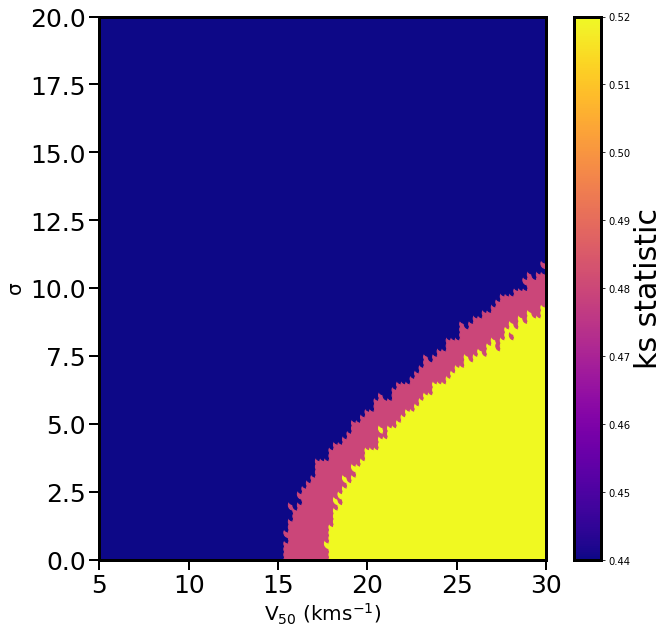

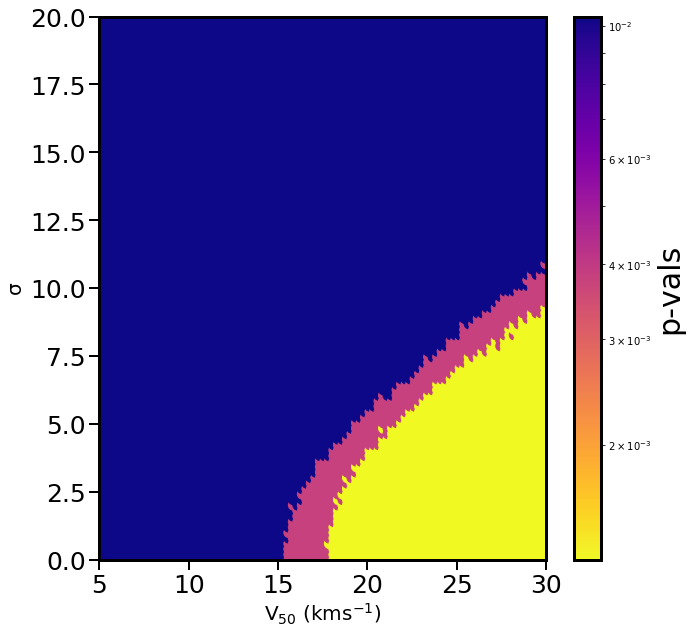

In [171]:
ks_sample = [xx[0] for xx in ks_total]
p_vals = [xx[1] for xx in ks_total]

#print ks_sample

mu_plot,sigma_plot = [],[]

#print sorted(ks_sample)

for mu_select in mu_list:
    for sigma_select in sigma_list:
        mu_plot.append(mu_select)
        sigma_plot.append(sigma_select)

min_index = np.argmin(ks_sample)

#print 'mu: {}, sigma: {}, ks: {}'.format(mu_plot[min_index],sigma_plot[min_index],ks_sample[min_index])
        
#print ks_sample

plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([5.0,30.0])
plt.ylim([0.0,20.0])
plt.xlabel('$V_{50}$ $(km s^{-1})$',fontsize=20)
plt.ylabel(r'$\sigma$',fontsize=20)

plt.scatter(mu_plot,sigma_plot,c=ks_sample,cmap='plasma',s=100)
cbar = plt.colorbar()
cbar.set_label('ks statistic',fontsize=30)
plt.show()


plt.figure(2,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([5.0,30.0])
plt.ylim([0.0,20.0])
plt.xlabel('$V_{50}$ $(km s^{-1})$',fontsize=20)
plt.ylabel(r'$\sigma$',fontsize=20)

plt.scatter(mu_plot,sigma_plot,c=p_vals,cmap='plasma_r',norm=matplotlib.colors.LogNorm(),s=100)
cbar = plt.colorbar()
cbar.set_label('p-vals',fontsize=30)
plt.show()

In [7]:
mu_list = np.linspace(3.0,30.0,100)
sigma_list = np.linspace(0.0,20.0,100)

combined = np.stack(np.meshgrid(mu_list,sigma_list),-1).reshape(-1,2)
#how this above function works
# 1) meshgrid makes Nd mesh (this case 3d) where one dimension is the mu_list and one is the sigma_list
# 2) stack -1 takes the transpose?
# 3) and then you have to reshape the matrix to 2d

#Now I want to take in all of Tyler's sims and cut the data/calculate distances
#we want to do this separately to save time

#I think I want to save this data as a dictionary for easy calling

h = 0.6751

halo_dict = {}

for data_file in os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'):
    h_number = data_file.split('_')[2]
    f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'+data_file)
    Data_M = f_halos[:,3]
    Data_X = f_halos[:,0]*1000.0/h
    Data_Y = f_halos[:,1]*1000.0/h
    Data_Z = f_halos[:,2]*1000.0/h
    Data_Rvir = f_halos[:,5]/h
    Data_Vmax = f_halos[:,4]/h
    Data_Vpeak = f_halos[:,6]

    M_t = 5.0

    Vmax_mask = (Data_M>M_t)

    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    Data_cens_cut = np.vstack((Data_X_cut,Data_Y_cut,Data_Z_cut)).T
    Data_Vpeak_cut = Data_Vpeak[Vmax_mask]
    Data_Vmax_cut = Data_Vmax[Vmax_mask]

    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    host_cen = np.array([Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]])

    coord_dist = Data_cens_cut - host_cen
    distances_from_center = np.linalg.norm(coord_dist,axis=1)

    halo_dict[h_number] = {'mass':Data_M_cut,'Vpeak':Data_Vpeak_cut,'Vmax':Data_Vmax_cut,'distances':distances_from_center}

In [8]:
#Poission maximum likelihood

#as per my discussion with Ryan, we probably don't want to use chi-squared because that assumes the pdf of your data is
#Gaussian (which it probably isn't), additionally because we have very low number statistics even if our data
#was Gaussian it still wouldn't be a good idea.

#The basic formula is log(L) = Sum -lambda + k log(lambda)
#lambda is the number of events in each bin (differential) and k the expected

mu_list = np.linspace(0.1,30.0,100)
sigma_list = np.linspace(0.0,20.0,100)

#okay now that I have that I need to find an efficient way to apply the "coin flip" to this multiple times for
#each run of this matrix

#1) apply cdf to the Vpeak of one sim multiple times

r_list = np.linspace(0.0,50.0,26)
r_list_plot = [(r_list[ii]+r_list[ii+1])/2.0 for ii in range(len(r_list)-1)]

f_dat = np.loadtxt('../../Sats_data.csv',delimiter=',',dtype=object)
gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

data_hist, data_bins = np.histogram(gal_dist,bins=r_list)
galaxies_hist_cum = np.cumsum(data_hist)

def normal_cdf(x,sigma,mu):
    return 0.5*(1.0+erf((x-mu)/(sigma*np.sqrt(2.0))))

def Poission_log_likelihood(data,model):
    loglike = -1.0*np.sum(-model + data*np.log(model))
    return loglike

cf_matrix = random.random_sample((len(combined[:,0]),len(Data_M_cut)))
print len(cf_matrix[0])

#Now I want to apply the cdf function to all the Vpeak data
#this will give an array for each sim with the len of how many halos are in that sim

n_iter = 10

ks_total = []
loglike_list =[]

for mu_select in mu_list:
    for sigma_select in sigma_list:
        popt = [sigma_select,mu_select]
        
        #now I need to initalize an empty matrix to hold all the data
        #for whatever reason the colums need to be the exact shape
        #you need, so in this case 1000 which is the number of bins
        
        hist_total = np.empty((0,25))
        
        for selected_halo in halo_dict.keys():
            Vpeak_select = halo_dict[selected_halo]['Vpeak']
            dist_select = halo_dict[selected_halo]['distances']
            
            #create a random sample that has a number of columns correspondng to the number of halos
            #and a number of rows that is the number of iterations I want
            
            dist_broadcast = np.broadcast_to(dist_select,(n_iter,len(dist_select)))

            #print len(Vpeak_select)

            cf_matrix = random.random_sample((n_iter,len(Vpeak_select)))
            #Now apply this matrix as a mask based on a matrix that is the probabilities of a halo
            #being filled according to the sigma and mu (this must be broadcast to the shape of
            #the cf matrix)

            fill_probabilities = np.broadcast_to(normal_cdf(Vpeak_select,*popt),(n_iter,len(Vpeak_select)))

            #np.broadcast_to(fill_probabilities,(n_iter,len(Vpeak_select)))
            assert cf_matrix.shape==fill_probabilities.shape

            #apply fill probabilities to cf_matrix

            cf_mask = (fill_probabilities>cf_matrix)

            #now I need to use a masked array in order to preseve shape:
            masked_distances = np.ma.array(dist_broadcast,mask=np.logical_not(cf_mask))

            assert fill_probabilities.shape==masked_distances.shape

            #is there a way I can bin these histograms which takes into account the fact that data is missing?
            #I could potentially use apply along axis method

            r_bins = np.linspace(0.0,50.0,26)

            histogram_matrix = np.apply_along_axis(lambda a: np.histogram(a.compressed(),bins=r_bins)[0], 1, masked_distances)
            cumulative_histogram_matrix = np.cumsum(histogram_matrix,axis=1)

            hist_total = np.concatenate([hist_total,cumulative_histogram_matrix])
            
        select_med_line = np.asarray([np.mean(hist_total[:,ii]) for ii in range(len(hist_total[0]))])
        ks_test = scipy.stats.ks_2samp(galaxies_hist_cum,select_med_line)
        
        #print type(data_hist), type(select_med_line)
        log_like = Poission_log_likelihood(data_hist,select_med_line)
        
        ks_total.append(ks_test)
        loglike_list.append(log_like)

7686


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in divide


mu: 0.1, sigma: 0.0, ks: 557.485183237


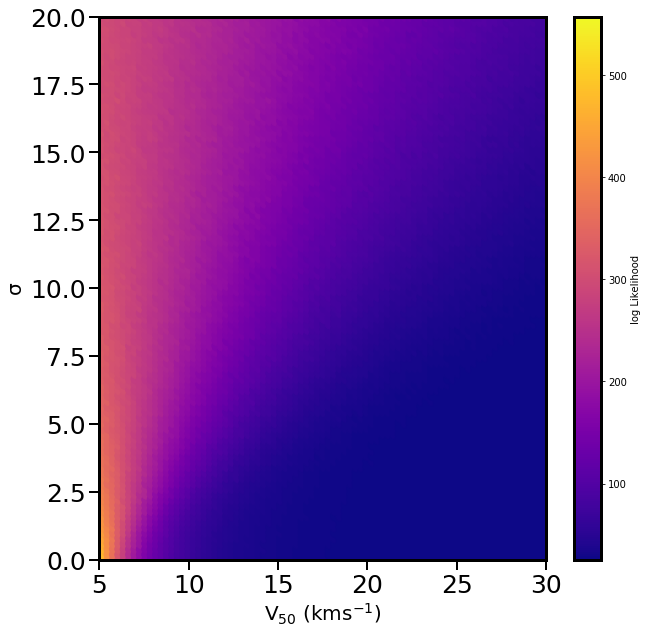

In [9]:
#ks_sample = [xx[0] for xx in ks_total]

mu_plot,sigma_plot = [],[]

#print sorted(ks_sample)

for mu_select in mu_list:
    for sigma_select in sigma_list:
        mu_plot.append(mu_select)
        sigma_plot.append(sigma_select)

max_index = np.argmax(loglike_list)

print 'mu: {}, sigma: {}, ks: {}'.format(mu_plot[max_index],sigma_plot[max_index],loglike_list[max_index])
        
#print ks_sample

plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([5.0,30.0])
plt.ylim([0.0,20.0])
plt.xlabel('$V_{50}$ $(km s^{-1})$',fontsize=20)
plt.ylabel('$\sigma$',fontsize=20)

plt.scatter(mu_plot,sigma_plot,c=loglike_list,cmap='plasma',s=100)
cbar = plt.colorbar()
cbar.set_label('log Likelihood')
plt.show()

In [175]:
#chi squared test

#Anna suggested I do chi-squared instead of KS, this way I can actually integrate the "width" of the distribution
#I have no idea how this actually works
#
#Important note: the cov. function in numpy takes in an array where each row is a varible (in my case a radius bin?)
#and the column is a single observation (bootstrapped compilation?)
#
#Now I want to create an NXM array where the number of columns is the number of bootstrap resamplings of 
#the data and the number of rows is the radius bins, and feed that to the covariance program
#
#Then Chi-square is just a vector where each bin is the average number at r averaged over all bootstrap
#resamplings for every r bin that I'm looking at, with the final calculation being
#
# chi-sq = V.T * Covariance_matrix * V
#
#Why do I need to bootstrap?

#Poission maximum likelihood

#as per my discussion with Ryan, we probably don't want to use chi-squared because that assumes the pdf of your data is
#Gaussian (which it probably isn't), additionally because we have very low number statistics even if our data
#was Gaussian it still wouldn't be a good idea.

#The basic formula is log(L) = Sum -lambda + k log(lambda)
#lambda is the number of events in each bin (differential) and k the expected

mu_list = np.linspace(0.1,30.0,10)
sigma_list = np.linspace(0.0,20.0,10)

#okay now that I have that I need to find an efficient way to apply the "coin flip" to this multiple times for
#each run of this matrix

#1) apply cdf to the Vpeak of one sim multiple times

r_list = np.linspace(20.0,50.0,6)
r_list_plot = [(r_list[ii]+r_list[ii+1])/2.0 for ii in range(len(r_list)-1)]

f_dat = np.loadtxt('../../Sats_data.csv',delimiter=',',dtype=object)
gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

data_hist, data_bins = np.histogram(gal_dist,bins=r_list)
galaxies_hist_cum = np.cumsum(data_hist)

def normal_cdf(x,sigma,mu):
    return 0.5*(1.0+erf((x-mu)/(sigma*np.sqrt(2.0))))

def Poission_log_likelihood(data,model):
    loglike = -1.0*np.sum(-model + data*np.log(model))
    return loglike

cf_matrix = random.random_sample((len(combined[:,0]),len(Data_M_cut)))
print len(cf_matrix[0])

#Now I want to apply the cdf function to all the Vpeak data
#this will give an array for each sim with the len of how many halos are in that sim

n_iter = 10

chi_squared_list = []

for mu_select in mu_list:
    for sigma_select in sigma_list:
        popt = [sigma_select,mu_select]
        
        #now I need to initalize an empty matrix to hold all the data
        #for whatever reason the colums need to be the exact shape
        #you need, so in this case 1000 which is the number of bins
        
        hist_total = np.empty((0,5))
        
        for selected_halo in halo_dict.keys():
            Vpeak_select = halo_dict[selected_halo]['Vpeak']
            dist_select = halo_dict[selected_halo]['distances']
            
            #create a random sample that has a number of columns correspondng to the number of halos
            #and a number of rows that is the number of iterations I want
            
            dist_broadcast = np.broadcast_to(dist_select,(n_iter,len(dist_select)))

            #print len(Vpeak_select)

            cf_matrix = random.random_sample((n_iter,len(Vpeak_select)))
            #Now apply this matrix as a mask based on a matrix that is the probabilities of a halo
            #being filled according to the sigma and mu (this must be broadcast to the shape of
            #the cf matrix)

            fill_probabilities = np.broadcast_to(normal_cdf(Vpeak_select,*popt),(n_iter,len(Vpeak_select)))

            #np.broadcast_to(fill_probabilities,(n_iter,len(Vpeak_select)))
            assert cf_matrix.shape==fill_probabilities.shape

            #apply fill probabilities to cf_matrix

            cf_mask = (fill_probabilities>cf_matrix)

            #now I need to use a masked array in order to preseve shape:
            masked_distances = np.ma.array(dist_broadcast,mask=np.logical_not(cf_mask))

            assert fill_probabilities.shape==masked_distances.shape

            #is there a way I can bin these histograms which takes into account the fact that data is missing?
            #I could potentially use apply along axis method

            r_bins = np.linspace(20.0,50.0,6)

            histogram_matrix = np.apply_along_axis(lambda a: np.histogram(a.compressed(),bins=r_bins)[0], 1, masked_distances)
            cumulative_histogram_matrix = np.cumsum(histogram_matrix,axis=1)

            hist_total = np.concatenate([hist_total,cumulative_histogram_matrix])
        
        #note in order to use the covariance matrix correctly I need the transpose of the 
        #hist_total matrix, so that each column is a different run
        #Okay so, it seems like I have to restrict my matrix to bins were n>0 or else
        #the covariance matrix fails
        
        hist_tot_trans = hist_total.T
        
        #print hist_tot_trans
        
        covariance = np.cov(hist_total.T)
        
        mean_matrix = np.mean(hist_tot_trans,axis=1)
        assert len(mean_matrix)==len(galaxies_hist_cum)
        vector_for_chi = mean_matrix-galaxies_hist_cum
        
        chi_squared = np.sum(vector_for_chi.T*np.linalg.inv(covariance)*vector_for_chi)
        
        chi_squared_list.append(ks_test)


7686


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: divide by zero encountered in divide


LinAlgError: Singular matrix

In [ ]:
#There's one interesting thing happening here
#it seems like for the KS test (and maybe Poisson) if I restrict my 
#fitting to radii where there are real galaxies a best fit parameter becomes clear
#whereas if you fit down to zero it tends to arbitrarily prefer lower Mu, kind of without limit
#I want to figure out why this is, so I think I'm going to set up a couple of tests where 
#I have a model that works well for the full fit and for the partial fit, and see 
#what those models look like in reality

#begin by applying the filter to just the radial functions
#without a radial correction

#okay here are the vmax bins, I might eventually fit a function
#actually I should just fit a function
def normal_cdf(x,sigma,mu):
    return 0.5*(1.0+erf((x-mu)/(sigma*np.sqrt(2.0))))

#now if I use a normalized cdf the fit parameters are sigma = 2.66718967  mu = 20.98533531 for Vmax

popt_good_non_zero = [1.0, 8.0]
popt_good_zero = [0.0,0.0]
#popt_low = [2.66718967, 5.0]

h = 0.6751

disk_files = len(os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'))

good_zero_hist_matrix = np.zeros((disk_files*10,25))
good_non_zero_hist_matrix = np.zeros((disk_files*10,25))

good_zero_hist_matrix_full = np.zeros((disk_files*10,25)) 
good_non_zero_hist_matrix_full = np.zeros((disk_files*10,25))

disk_iter = 0
    
for data_file in os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'):
    for kk in range(10):
        
        f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'+data_file)
        Data_M = f_halos[:,3]
        Data_X = f_halos[:,0]*1000.0/h
        Data_Y = f_halos[:,1]*1000.0/h
        Data_Z = f_halos[:,2]*1000.0/h
        Data_Rvir = f_halos[:,5]/h
        Data_Mass = f_halos[:,4]/h
        Data_Vpeak = f_halos[:,6]

        M_t = 5.0

        Vmax_mask = (Data_M>M_t)

        Data_X_cut = Data_X[Vmax_mask]
        Data_Y_cut = Data_Y[Vmax_mask]
        Data_Z_cut = Data_Z[Vmax_mask]
        Data_M_cut = Data_M[Vmax_mask]
        filled_frac = normal_cdf(Data_M_cut,*popt)
        Data_Rvir_cut = Data_Rvir[Vmax_mask]
        Data_cens_cut = np.vstack((Data_X_cut,Data_Y_cut,Data_Z_cut)).T
        Data_Vpeak_cut = Data_Vpeak[Vmax_mask]

        host_index = np.argmax(Data_M_cut)
        R_vir_host = Data_Rvir_cut[host_index]
        host_cen = np.array([Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]])

        coord_dist = Data_cens_cut - host_cen
        distances_from_center = np.linalg.norm(coord_dist,axis=1)

        filled_frac_good_zero = normal_cdf(Data_Vpeak_cut,*popt_good_zero)
        filled_frac_good_non_zero = normal_cdf(Data_Vpeak_cut,*popt_good_non_zero)

        weighted_coin_flip_good_zero = np.array([True if random.random() < xx else False for xx in filled_frac_good_zero])
        weighted_coin_flip_good_non_zero = np.array([True if random.random() < xx else False for xx in filled_frac_good_non_zero])
        #print len(Data_X), np.sum(Vmax_mask), np.sum(weighted_coin_flip)
        
        zero_hist, zero_bins = np.histogram(distances_from_center[weighted_coin_flip_good_zero],bins=np.linspace(20.0,50.0,26))
        zero_hist_c = np.cumsum(zero_hist)
        good_zero_hist_matrix[disk_iter] = zero_hist_c
        
        non_zero_hist, non_zero_bins = np.histogram(distances_from_center[weighted_coin_flip_good_non_zero],bins=np.linspace(20.0,50.0,26))
        non_zero_hist_c = np.cumsum(non_zero_hist)
        good_non_zero_hist_matrix[disk_iter] = non_zero_hist_c
        
        zero_full_hist, zero_full_bins = np.histogram(distances_from_center[weighted_coin_flip_good_zero],bins=np.linspace(0.0,50.0,26))
        zero_full_hist_c = np.cumsum(zero_full_hist)
        good_zero_hist_matrix_full[disk_iter] = zero_full_hist_c
        
        non_zero_full_hist, non_zero_full_bins = np.histogram(distances_from_center[weighted_coin_flip_good_non_zero],bins=np.linspace(0.0,50.0,26))
        non_zero_full_hist_c = np.cumsum(non_zero_full_hist)
        good_non_zero_hist_matrix_full[disk_iter] = non_zero_full_hist_c
    
        disk_iter += 1
    
r_list = np.linspace(20.0,50.0,26)
    
r_list_plot = [(r_list[ii]+r_list[ii+1])/2.0 for ii in range(len(r_list)-1)]


r_list_full = np.linspace(0.0,50.0,26)
    
r_list_full_plot = [(r_list_full[ii]+r_list_full[ii+1])/2.0 for ii in range(len(r_list_full)-1)]

good_zero_med_line = [np.mean(good_zero_hist_matrix[:,ii]) for ii in range(len(good_zero_hist_matrix[0]))]

good_non_zero_med_line = [np.mean(good_non_zero_hist_matrix[:,ii]) for ii in range(len(good_non_zero_hist_matrix[0]))]

good_zero_full_med_line = [np.mean(good_zero_hist_matrix_full[:,ii]) for ii in range(len(good_zero_hist_matrix_full[0]))]

good_non_zero_full_med_line = [np.mean(good_non_zero_hist_matrix_full[:,ii]) for ii in range(len(good_non_zero_hist_matrix_full[0]))]


f_dat = np.loadtxt('../../Sats_data.csv',delimiter=',',dtype=object)
gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

gal_hist, gal_bins = np.histogram(gal_dist,bins=r_list)
gal_hist_c = np.cumsum(gal_hist)

gal_hist_full, gal_bins_full = np.histogram(gal_dist,bins=r_list_full)
gal_hist_full_c = np.cumsum(gal_hist_full)

ks_zero = scipy.stats.ks_2samp(gal_hist_c,good_zero_med_line)
ks_non_zero = scipy.stats.ks_2samp(gal_hist_c,good_zero_med_line)

ks_zero_full = scipy.stats.ks_2samp(gal_hist_full_c,good_zero_full_med_line)
ks_non_zero_full = scipy.stats.ks_2samp(gal_hist_full_c,good_zero_full_med_line)

print ks_zero
print ks_non_zero

print ks_zero_full
print ks_non_zero_full
    
plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([0.0,300.0])
plt.ylim([1.0,500.0])
plt.xlabel('r (kpc)',fontsize=20)
plt.ylabel('log(N)',fontsize=20)
#plt.fill_between(r_list_plot,min_line,max_line,color='C0',alpha=0.5)
#plt.plot(r_list_plot,med_line,linewidth=3,color='C0',label='DMO runs')

plt.plot(r_list_full_plot,good_non_zero_full_med_line,linewidth=3,color='C0',label='non zero runs')

plt.plot(r_list_full_plot,good_zero_full_med_line,linewidth=3,color='C0',label='zero runs')

data_hist, data_bins, data_patches = plt.hist(gal_dist,bins=r_list,cumulative=True,histtype='step',linewidth=3,color='k',linestyle='--',label='Actual Galaxies')

plt.yscale('log')
plt.legend(loc=1, prop={'size': 20})
#plt.savefig('./all_halos_shade.png',bbox_inches='tight')
plt.show()

In [ ]:
r_list = np.linspace(20.0,50.0,26)
    
r_list_plot = [(r_list[ii]+r_list[ii+1])/2.0 for ii in range(len(r_list)-1)]


r_list_full = np.linspace(0.0,50.0,26)
    
r_list_full_plot = [(r_list_full[ii]+r_list_full[ii+1])/2.0 for ii in range(len(r_list_full)-1)]

good_zero_med_line = [np.mean(good_zero_hist_matrix[:,ii]) for ii in range(len(good_zero_hist_matrix[0]))]

good_non_zero_med_line = [np.mean(good_non_zero_hist_matrix[:,ii]) for ii in range(len(good_non_zero_hist_matrix[0]))]

good_zero_full_med_line = [np.mean(good_zero_hist_matrix_full[:,ii]) for ii in range(len(good_zero_hist_matrix_full[0]))]

good_non_zero_full_med_line = [np.mean(good_non_zero_hist_matrix_full[:,ii]) for ii in range(len(good_non_zero_hist_matrix_full[0]))]


f_dat = np.loadtxt('../../Sats_data.csv',delimiter=',',dtype=object)
gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

gal_hist, gal_bins = np.histogram(gal_dist,bins=r_list)
gal_hist_c = np.cumsum(gal_hist)

gal_hist_full, gal_bins_full = np.histogram(gal_dist,bins=r_list_full)
gal_hist_full_c = np.cumsum(gal_hist_full)

ks_zero = scipy.stats.ks_2samp(gal_hist_c,good_zero_med_line)
ks_non_zero = scipy.stats.ks_2samp(gal_hist_c,good_non_zero_med_line)

ks_zero_full = scipy.stats.ks_2samp(gal_hist_full_c,good_zero_full_med_line)
ks_non_zero_full = scipy.stats.ks_2samp(gal_hist_full_c,good_non_zero_full_med_line)

print ks_zero
print ks_non_zero

print ks_zero_full
print ks_non_zero_full
    
plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([0.0,50.0])
plt.ylim([1.0,100.0])
plt.xlabel('r (kpc)',fontsize=20)
plt.ylabel('log(N)',fontsize=20)
#plt.fill_between(r_list_plot,min_line,max_line,color='C0',alpha=0.5)
#plt.plot(r_list_plot,med_line,linewidth=3,color='C0',label='DMO runs')

plt.plot(r_list_full_plot,good_non_zero_full_med_line,linewidth=3,color='C0',label='non zero runs')

plt.plot(r_list_full_plot,good_zero_full_med_line,linewidth=3,color='C0',label='zero runs')

data_hist, data_bins, data_patches = plt.hist(gal_dist,bins=r_list,cumulative=True,histtype='step',linewidth=3,color='k',linestyle='--',label='Actual Galaxies')

plt.yscale('log')
plt.legend(loc=1, prop={'size': 20})
#plt.savefig('./all_halos_shade.png',bbox_inches='tight')
plt.show()

In [10]:
combined = np.stack(np.meshgrid(mu_list,sigma_list),-1).reshape(-1,2)
#how this above function works
# 1) meshgrid makes Nd mesh (this case 3d) where one dimension is the mu_list and one is the sigma_list
# 2) stack -1 takes the transpose?
# 3) and then you have to reshape the matrix to 2d

#Now I want to take in all of Tyler's sims and cut the data/calculate distances
#we want to do this separately to save time

#I think I want to save this data as a dictionary for easy calling

h = 0.6751

halo_dict = {}

for data_file in os.listdir('../../initial_test_with_ELVIS/Tyler_dmo_data_from_mt/'):
    h_number = data_file.split('_')[2]
    f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_dmo_data_from_mt/'+data_file)
    Data_M = f_halos[:,3]
    Data_X = f_halos[:,0]*1000.0/h
    Data_Y = f_halos[:,1]*1000.0/h
    Data_Z = f_halos[:,2]*1000.0/h
    Data_Rvir = f_halos[:,5]/h
    Data_Vmax = f_halos[:,4]/h
    Data_Vpeak = f_halos[:,6]

    M_t = 5.0

    Vmax_mask = (Data_M>M_t)

    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    Data_cens_cut = np.vstack((Data_X_cut,Data_Y_cut,Data_Z_cut)).T
    Data_Vpeak_cut = Data_Vpeak[Vmax_mask]
    Data_Vmax_cut = Data_Vmax[Vmax_mask]

    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    host_cen = np.array([Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]])

    coord_dist = Data_cens_cut - host_cen
    distances_from_center = np.linalg.norm(coord_dist,axis=1)

    halo_dict[h_number] = {'mass':Data_M_cut,'Vpeak':Data_Vpeak_cut,'Vmax':Data_Vmax_cut,'distances':distances_from_center}

In [12]:
#fit only where there's data

mu_list = np.linspace(5.0,30.0,100)
sigma_list = np.linspace(0.0,20.0,100)

#okay now that I have that I need to find an efficient way to apply the "coin flip" to this multiple times for
#each run of this matrix

#1) apply cdf to the Vpeak of one sim multiple times

r_list = np.linspace(20.0,50.0,26)
r_list_plot = [(r_list[ii]+r_list[ii+1])/2.0 for ii in range(len(r_list)-1)]

f_dat = np.loadtxt('../../Sats_data.csv',delimiter=',',dtype=object)
gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

data_hist, data_bins = np.histogram(gal_dist,bins=r_list)
galaxies_hist_cum = np.cumsum(data_hist)

print np.min(gal_dist)

def normal_cdf(x,sigma,mu):
    return 0.5*(1.0+erf((x-mu)/(sigma*np.sqrt(2.0))))

#Now I want to apply the cdf function to all the Vpeak data
#this will give an array for each sim with the len of how many halos are in that sim

n_iter = 10

ks_total = []

for mu_select in mu_list:
    for sigma_select in sigma_list:
        popt = [sigma_select,mu_select]
        
        #now I need to initalize an empty matrix to hold all the data
        #for whatever reason the colums need to be the exact shape
        #you need, so in this case 1000 which is the number of bins
        
        hist_total = np.empty((0,25))
        
        for selected_halo in halo_dict.keys():
            Vpeak_select = halo_dict[selected_halo]['Vpeak']
            dist_select = halo_dict[selected_halo]['distances']
            
            #create a random sample that has a number of columns correspondng to the number of halos
            #and a number of rows that is the number of iterations I want
            
            dist_broadcast = np.broadcast_to(dist_select,(n_iter,len(dist_select)))

            #print len(Vpeak_select)

            cf_matrix = random.random_sample((n_iter,len(Vpeak_select)))
            #Now apply this matrix as a mask based on a matrix that is the probabilities of a halo
            #being filled according to the sigma and mu (this must be broadcast to the shape of
            #the cf matrix)

            fill_probabilities = np.broadcast_to(normal_cdf(Vpeak_select,*popt),(n_iter,len(Vpeak_select)))

            #np.broadcast_to(fill_probabilities,(n_iter,len(Vpeak_select)))
            assert cf_matrix.shape==fill_probabilities.shape

            #apply fill probabilities to cf_matrix

            cf_mask = (fill_probabilities>cf_matrix)

            #now I need to use a masked array in order to preseve shape:
            masked_distances = np.ma.array(dist_broadcast,mask=np.logical_not(cf_mask))

            assert fill_probabilities.shape==masked_distances.shape

            #is there a way I can bin these histograms which takes into account the fact that data is missing?
            #I could potentially use apply along axis method

            r_bins = np.linspace(20.0,50.0,26)

            histogram_matrix = np.apply_along_axis(lambda a: np.histogram(a.compressed(),bins=r_bins)[0], 1, masked_distances)
            cumulative_histogram_matrix = np.cumsum(histogram_matrix,axis=1)
            
            #print cumulative_histogram_matrix

            hist_total = np.concatenate([hist_total,cumulative_histogram_matrix])
            
        select_med_line = np.array([np.mean(hist_total[:,ii]) for ii in range(len(hist_total[0]))])
        
        ks_test = scipy.stats.ks_2samp(galaxies_hist_cum,select_med_line)
        #print 'mu: {}, sigma: {}'.format(mu_select,sigma_select)
        #print galaxies_hist_cum
        #print select_med_line
        #print ks_test
        
        ks_total.append(ks_test)

23.0


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:66: RuntimeWarning: invalid value encountered in greater


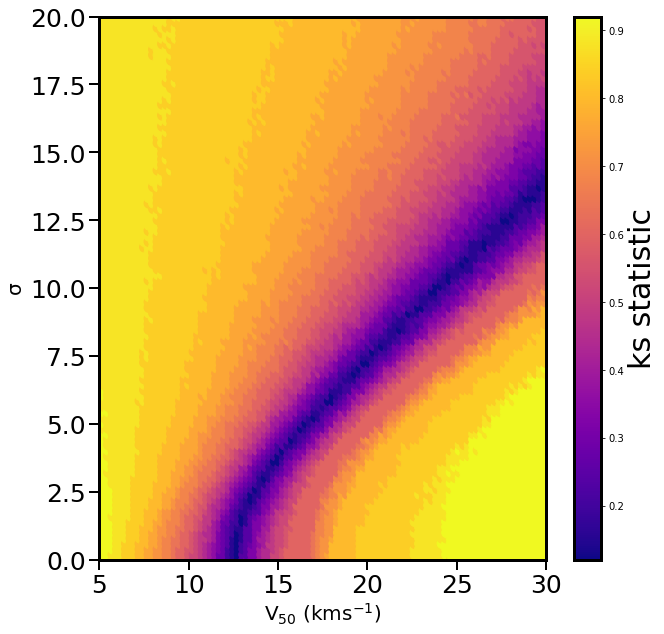

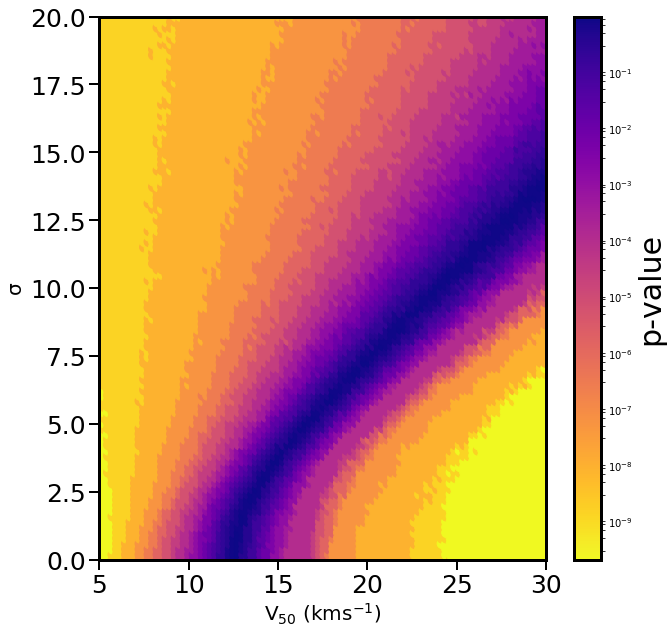

In [13]:
ks_sample = [xx[0] for xx in ks_total]
p_vals = [xx[1] for xx in ks_total]

#print ks_sample

mu_plot,sigma_plot = [],[]

#print sorted(ks_sample)

for mu_select in mu_list:
    for sigma_select in sigma_list:
        mu_plot.append(mu_select)
        sigma_plot.append(sigma_select)

min_index = np.argmin(ks_sample)

#print 'mu: {}, sigma: {}, ks: {}'.format(mu_plot[min_index],sigma_plot[min_index],ks_sample[min_index])
        
#print ks_sample

plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([5.0,30.0])
plt.ylim([0.0,20.0])
plt.xlabel('$V_{50}$ $(km s^{-1})$',fontsize=20)
plt.ylabel(r'$\sigma$',fontsize=20)

plt.scatter(mu_plot,sigma_plot,c=ks_sample,cmap='plasma',s=100)
cbar = plt.colorbar()
cbar.set_label('ks statistic',fontsize=30)
plt.show()


plt.figure(2,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([5.0,30.0])
plt.ylim([0.0,20.0])
plt.xlabel('$V_{50}$ $(km s^{-1})$',fontsize=20)
plt.ylabel(r'$\sigma$',fontsize=20)

plt.scatter(mu_plot,sigma_plot,c=p_vals,cmap='plasma_r',norm=matplotlib.colors.LogNorm(),s=100)
cbar = plt.colorbar()
cbar.set_label('p-value',fontsize=30)
plt.show()